## Purpose of Notebook

- Last update: 19 July 2021

The goal is to build a high performance model on inlier either by removing outliers from the original dataset before training any model on or giving a less weight to the outliers while training a model. The novelty handling process would be different. One approach could be to isolate them into a seperate clusters and build a model just on the inliers or have a more general model that can incorporate both inliers and novelties.

Study *Local Outlier factor*

In [20]:
import matplotlib.pyplot as pl
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.neighbors import LocalOutlierFactor
import sys
sys.path.append('../src/')
from data_generator import ToyDataGenerator

In [2]:
n_samples = 300
n_features = 3
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [3]:
dgenerator = ToyDataGenerator(n_inliers, n_features)

In [4]:
X = dgenerator.feature_generator()
y = dgenerator.target_generator_independent(X, n_features)

Coefficients are []
indeces are []
Coefficients are [3]
indeces are [2]
Coefficients are [-1 -2]
indeces are [2 1]


In [5]:
X_outlier, y_outlier = dgenerator.outlier_generator(X, y)

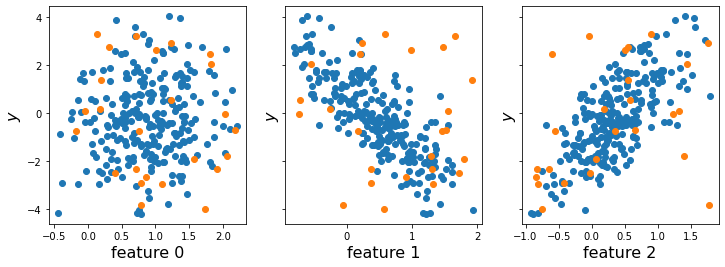

In [8]:
fig, ax = pl.subplots(1, X.shape[1], figsize=(4*X.shape[1],4), sharey=True)
for i in range(X.shape[1]):
    ax[i].scatter(X[:,i], y)
    ax[i].scatter(X_outlier[:,i], y_outlier)
    ax[i].set_xlabel(f'feature {i}', fontsize=16)
    ax[i].set_ylabel(r'$y$', fontsize=16)
#     ax[i].set_title(f"features{i}")
#fig.savefig('../doc/figs/y_vs_3features.pdf', bbox_inches='tight')

In [13]:
df = pd.DataFrame(X, columns=[f'x{i}' for i in range(X.shape[1])])
df['y'] = y

<Figure size 576x576 with 0 Axes>

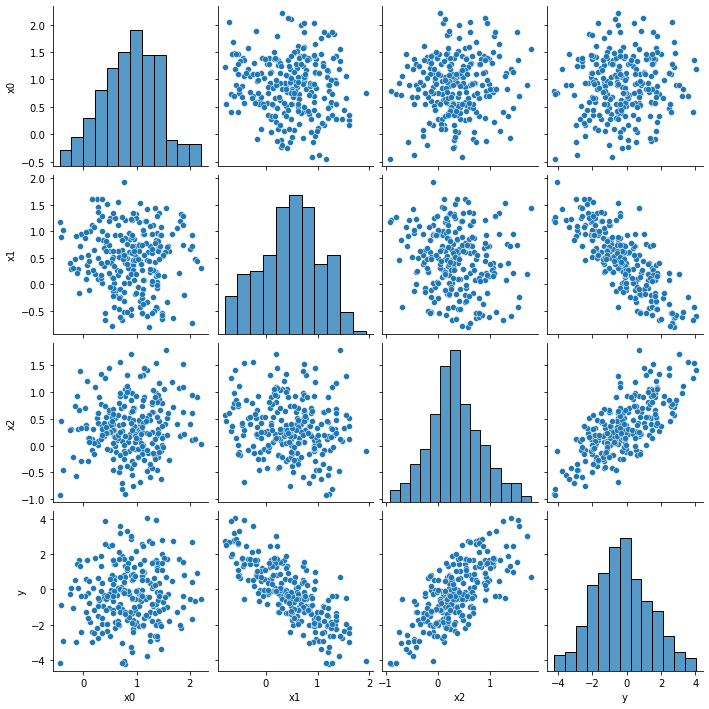

In [14]:
pl.figure(figsize=(8,8))
sns.pairplot(df)
#pl.savefig('../doc/figs/y_vs_3features_pairplot.pdf', bbox_inches='tight')

### Apply LOF to the generated dataset
We follow two distinct approches here to identify the outliers:
- Apply *LOF* just to the feature space with specitied contamination.
- Apply *LOF* to both feature and target space.

### Construct the whole dataset

In [17]:
X_all = np.r_[X, X_outlier]
y_all = np.r_[y, y_outlier]

In [18]:
outliers_fraction = 0.1

In [21]:
lof = LocalOutlierFactor(n_neighbors=30, contamination= outliers_fraction)

### Apply to feature space

In [22]:
lof_predict = lof.fit_predict(X_all)

In [23]:
X_all.shape, y_all.shape

((280, 3), (280,))

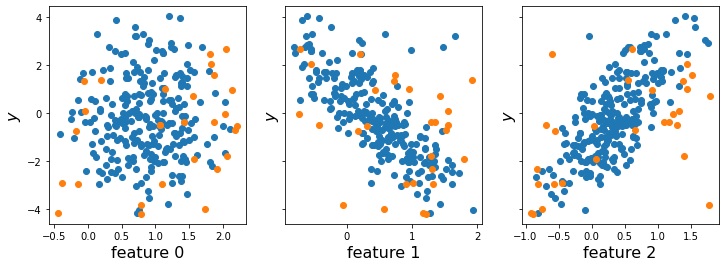

In [24]:
fig, ax = pl.subplots(1, X.shape[1], figsize=(4*X.shape[1],4), sharey=True)
for i in range(X.shape[1]):
    ax[i].scatter(X_all[lof_predict>0,i], y_all[lof_predict>0])
    ax[i].scatter(X_all[lof_predict<0,i], y_all[lof_predict<0])
    ax[i].set_xlabel(f'feature {i}', fontsize=16)
    ax[i].set_ylabel(r'$y$', fontsize=16)
#     ax[i].set_title(f"features{i}")
#fig.savefig('../doc/figs/y_vs_3features_lof_X.pdf', bbox_inches='tight')

### Apply to both feature and target space

In [25]:
lof_predict = lof.fit_predict(np.c_[X_all, y_all])

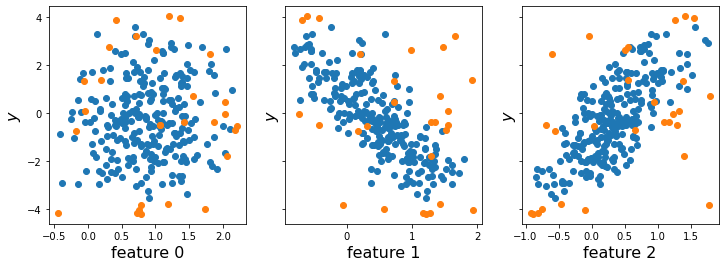

In [26]:
fig, ax = pl.subplots(1, X.shape[1], figsize=(4*X.shape[1],4), sharey=True)
for i in range(X.shape[1]):
    ax[i].scatter(X_all[lof_predict>0,i], y_all[lof_predict>0])
    ax[i].scatter(X_all[lof_predict<0,i], y_all[lof_predict<0])
    ax[i].set_xlabel(f'feature {i}', fontsize=16)
    ax[i].set_ylabel(r'$y$', fontsize=16)
#     ax[i].set_title(f"features{i}")
#fig.savefig('../doc/figs/y_vs_3features_lof_Xy.pdf', bbox_inches='tight')